# Ultrasounds data augmentation

In [1]:
from collections import defaultdict, Counter
import os
import random
from typing import List

import matplotlib.pyplot as plt
import numpy as np

from src.data.image import Ultrasound, Image
from src.data.data_transforms import Resize, DynamicRangeScaling, Compose, RandomNoise, Blur, AxisTranspose, FDATransform
from src.data.us_dataset import UsDataset, split_us_dataset
from src.models.clasifier_model import ImageClassifier
from src.models.classifier_trainer import ClassifierTrainer
from src.options.classifier_options import ClassifierOptions
from src.utils import load_us_data, obtain_histogram

labels = {
        "bladder": 0,
        "bowel": 1,
        "gallbladder": 2,
        "kidney": 3,
        "liver": 4,
        "spleen": 5,
    }
inverse_labels = {label: key for key, label in labels.items()}

## 0. Previous work

Before everything, we must look for a good cone segmentation and save it. It will be used for all images in USnotAI dataset, since all of them have the same orientation.

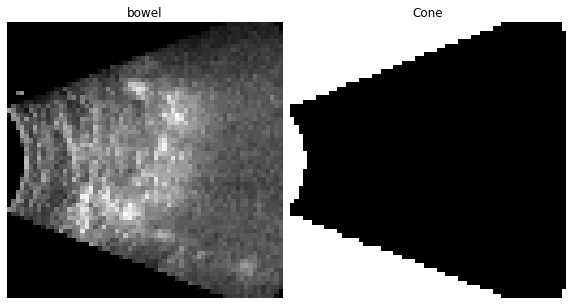

In [2]:
data = load_us_data()
image_number = 5
us = data[image_number]
cone = Image(us.cone_array, "Cone")
f = Image.create_image_grid([us,cone])

This image was selected as cone reference. Results were saved in cone.png. 

## 1. Data Exploration 

The first part of the work will consist in exploring the dataset and create the artificial dataset that emulates US umages from other equipment with lower frequency, lower gain and other image processing

The number of images per label in the dataset is:
Counter({'bladder': 61, 'kidney': 61, 'bowel': 61, 'spleen': 61, 'liver': 61, 'gallbladder': 61})


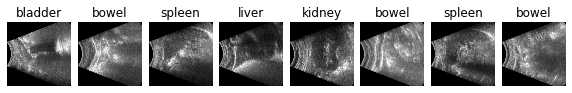

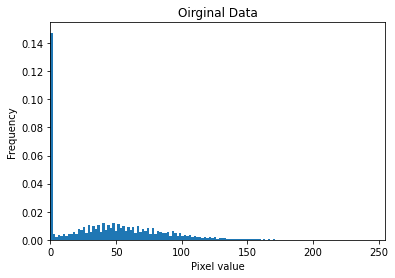

In [2]:
data = load_us_data()

labels_ocurrences = map(lambda us: us.label, data)
label_counts = Counter(labels_ocurrences)

print(f"The number of images per label in the dataset is:\n{label_counts}")

#Let's print some examples to adquire some insights about how our US look like
_ = Ultrasound.create_image_grid(data[::50])

# Finally, we make the histogram of the dataset
_ = obtain_histogram(data, sample_size=50, title="Oirginal Data")


Now, we can proceed to make our simulated data from the original dataset

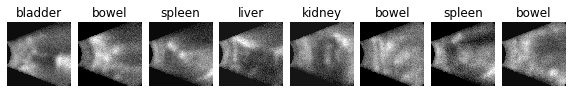

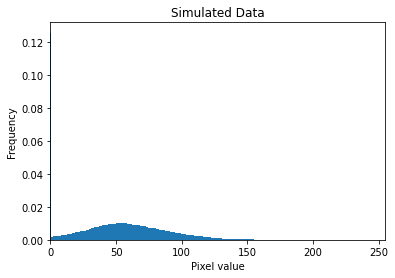

In [3]:
domain_transform = Compose([
    AxisTranspose([1]),
    Blur(1.5),
    RandomNoise(0,15) 
])

simulated_data = [Ultrasound(domain_transform(us.torch_tensor), label=us.label, cone=us.cone_array) for us in data]

#Let's print some examples to adquire some insights about how our simulated US look like
_ = Ultrasound.create_image_grid(simulated_data[::50])

# Finally, we make the histogram of the simulated dataset
_ = obtain_histogram(simulated_data, sample_size=50, title="Simulated Data")

### 1.3 Saving datasets for CycleGan

In [ ]:
def save_us_dataset(data:List[Ultrasound], dirpath:str):
    counter = Counter()
    for us in data:
        counter[us.label] += 1
        us.save_image(dirpath, file_name=f"{us.label}-{str(counter[us.label]).zfill(4)}.png", pil_convert_mode="L")

folders = ["trainA", "trainB", "testA", "testB"]
for folder in folders:
    os.makedirs(f"data_for_cyclegan/{folder}")

original_train_data, original_validation_data = split_us_dataset(data, labels.keys(), validation_fraction=0.05)
adapted_train_data, adapted_validation_data = split_us_dataset(simulated_data, labels.keys(), validation_fraction=0.05)

save_us_dataset(original_train_data, "data_for_cyclegan/trainA")
save_us_dataset(adapted_train_data, "data_for_cyclegan/trainB")
save_us_dataset(original_validation_data, "data_for_cyclegan/testA")
save_us_dataset(adapted_validation_data, "data_for_cyclegan/testB")


## 2. Data Harmonization

### 2.1 FDA

In this part we will apply Fourier Domain Adaptation to the original dataset in order to shift its domain into the target data, which is the simulated. If we train a model on these data it should be able of make it better in classificate the simulated images. 

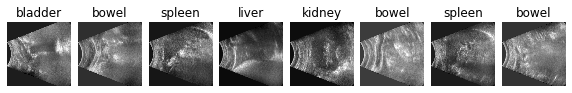

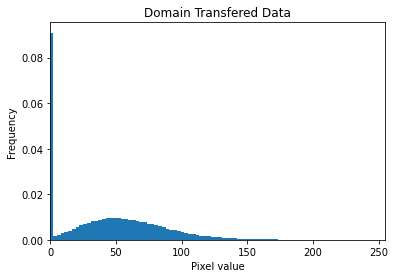

In [4]:
L = 0.05
random.seed(1234)
fda_original_data = []

for i, us in enumerate(data):
    target_us = random.choice(simulated_data)
    transform = FDATransform(target_us.torch_tensor, L)
    adapted_us = Ultrasound(transform(us.torch_tensor), label=us.label, cone=us.cone_array)
    # if i==0:
    #     us.plot(figsize=(3,3))
    #     target_us.plot(figsize=(3,3))
    #     adapted_us.plot(figsize=(3,3))
    fda_original_data.append(adapted_us)

#Let's print some examples to adquire some insights about how our simulated US look like
_ = Ultrasound.create_image_grid(fda_original_data[::50])

# Finally, we make the histogram of the simulated dataset
_ = obtain_histogram(fda_original_data, sample_size=50, title="Domain Transfered Data")

### 2.2 CycleGan Harmonization

This part was done by training a CycleGan with original dataset (dataset A) and simulated dataset (datset B). The traninning was done using google colab on the original repo. The trained model was downloaded and use to create the domain adapted data. Results are shown in this section

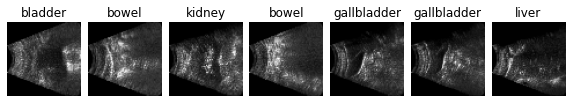

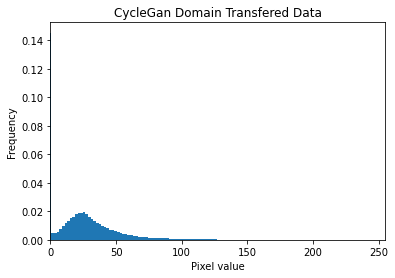

In [5]:
# For cyclegan, we need to manualy load data since images are rotated and have a greater resolution
cyclegan_data_path = "Data/USAnotAI_CyleGan"
files = [file for file in os.scandir(cyclegan_data_path) if file.name not in ("source.md", "cone.png")]
cone = Image.from_path(os.path.join(cyclegan_data_path, "cone.png"), "cone")
cyclegan_data = [Image.from_path(file.path, file.name.split("-")[0]) for file in files]
for img in cyclegan_data:
    img.image = img.image.T
resize = Resize((3, 64,64))
cyclegan_data = [Ultrasound(resize(img.torch_tensor - img.image.min()), img.label, cone.image) for img in cyclegan_data]
for us in cyclegan_data:
    us.dark_cone()

#Let's print some examples to adquire some insights about how our simulated US look like
_ = Ultrasound.create_image_grid(cyclegan_data[::50])

# Finally, we make the histogram of the simulated dataset
_ = obtain_histogram(cyclegan_data, sample_size=50, title="CycleGan Domain Transfered Data")

## 3. Training Classifiers

### 3.1 Without Harmonization

-----------------------MODEL OPTIONS------------------------
Name                     ----> us_without harmonization
Device                   ---->                      cpu
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        6
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->             CrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       20
Image_size               ---->                 (64, 64)
Num_threads              ---->                        4
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                 (0, 255)

---------------------Training Epoch: 0----------------------
Running training batch 19/19
Training

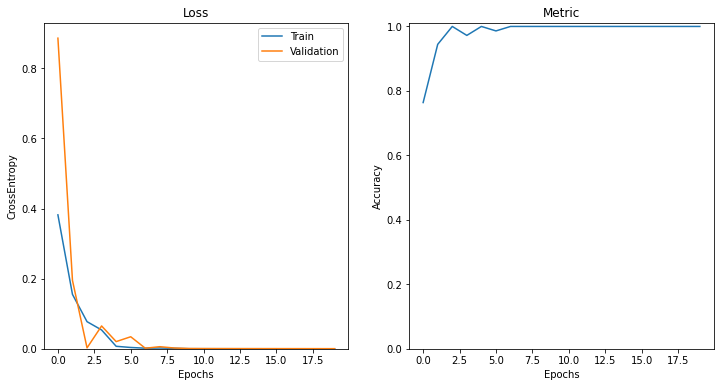

In [7]:
parser = ClassifierOptions()
parser.rewrite_option("name","us_without_harmonization")
parser.rewrite_option("crop_dynamic_range", (0,255))
parser.rewrite_option("n_classes", 6)
parser.rewrite_option("loss_function", "CrossEntropy")
parser.rewrite_option("num_threads", 4)
parser.rewrite_option("epochs", 20)
parser.print_options()

transforms = [
    Resize(parser.image_size),
    DynamicRangeScaling(parser.model_dynamic_range,parser.crop_dynamic_range)
]

train_data, validation_data = split_us_dataset(data, labels.keys(), 0.2)

train_dataset = UsDataset(train_data, label_dict=labels, transforms=transforms)
validation_dataset = UsDataset(validation_data, label_dict=labels, transforms=transforms)

model = ImageClassifier(parser)
trainer = ClassifierTrainer(model)
trainer.set_dataloaders(train_dataset, validation_dataset)
trainer.train_model()
fig = trainer.plot_losses()

### 3.2 With FDA

-----------------------MODEL OPTIONS------------------------
Name                     ---->                   us_fda
Device                   ---->                      cpu
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        6
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->             CrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       20
Image_size               ---->                 (64, 64)
Num_threads              ---->                        4
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                 (0, 255)

---------------------Training Epoch: 0----------------------
Running training batch 19/19
Training

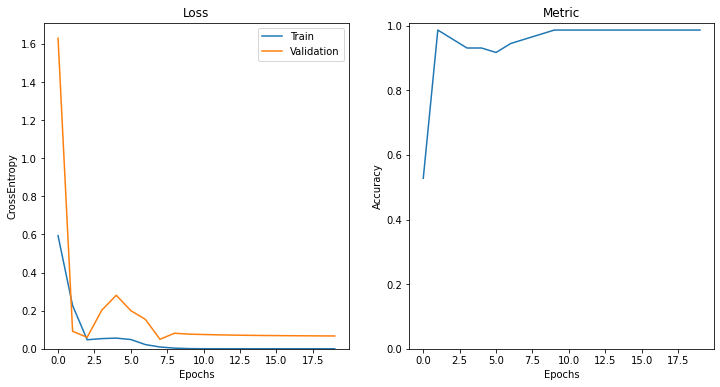

In [6]:
parser = ClassifierOptions()
parser.rewrite_option("name","us_fda")
parser.rewrite_option("crop_dynamic_range", (0,255))
parser.rewrite_option("n_classes", 6)
parser.rewrite_option("loss_function", "CrossEntropy")
parser.rewrite_option("num_threads", 4)
parser.rewrite_option("epochs", 20)
parser.print_options()

transforms = [
    Resize(parser.image_size),
    DynamicRangeScaling(parser.model_dynamic_range,parser.crop_dynamic_range)
]

train_data, validation_data = split_us_dataset(fda_original_data, labels.keys(), 0.2)

train_dataset = UsDataset(train_data, label_dict=labels, transforms=transforms)
validation_dataset = UsDataset(validation_data, label_dict=labels, transforms=transforms)

model = ImageClassifier(parser)
trainer = ClassifierTrainer(model)
trainer.set_dataloaders(train_dataset, validation_dataset)
trainer.train_model()
fig = trainer.plot_losses()

### 3.3 With CycleGan

-----------------------MODEL OPTIONS------------------------
Name                     ---->              us_cyclegan
Device                   ---->                      cpu
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        6
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->             CrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       20
Image_size               ---->                 (64, 64)
Num_threads              ---->                        4
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                 (0, 255)

---------------------Training Epoch: 0----------------------
Running training batch 18/18
Training

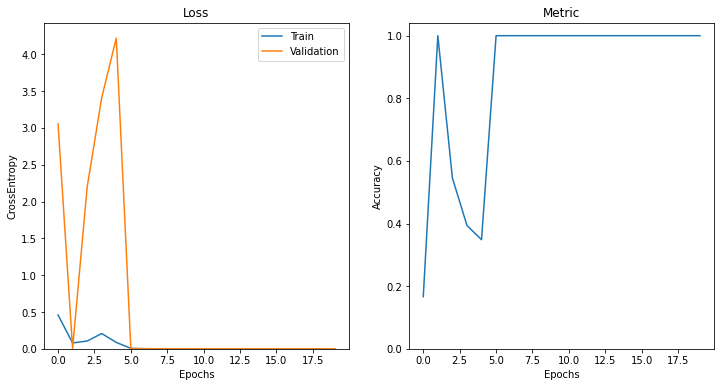

In [6]:
parser = ClassifierOptions()
parser.rewrite_option("name","us_cyclegan")
parser.rewrite_option("crop_dynamic_range", (0,255))
parser.rewrite_option("n_classes", 6)
parser.rewrite_option("loss_function", "CrossEntropy")
parser.rewrite_option("num_threads", 4)
parser.rewrite_option("epochs", 20)
parser.print_options()

transforms = [
    Resize(parser.image_size),
    DynamicRangeScaling(parser.model_dynamic_range,parser.crop_dynamic_range)
]

train_data, validation_data = split_us_dataset(cyclegan_data, labels.keys(), 0.2)

train_dataset = UsDataset(train_data, label_dict=labels, transforms=transforms)
validation_dataset = UsDataset(validation_data, label_dict=labels, transforms=transforms)

model = ImageClassifier(parser)
trainer = ClassifierTrainer(model)
trainer.set_dataloaders(train_dataset, validation_dataset)
trainer.train_model()
fig = trainer.plot_losses()

## 4. Model Evaluation

In [7]:
def get_validation_stats(model_name: str, title:str) -> None:

    #Load model
    model_path = f"saved_models/{model_name}"
    parser, model = ImageClassifier.load_pretrained_model(model_path)
    transforms = Compose([
        Resize(parser.image_size),
        DynamicRangeScaling(parser.model_dynamic_range, parser.crop_dynamic_range)
    ])

    classification_stats = defaultdict(list)
    # Run inference over the simulated dataset
    for data in simulated_data:
        us = transforms(data.torch_tensor)
        predict = model.inference(us.unsqueeze(0).float())
        # Record if the label is correctly classified
        success = inverse_labels[predict]==data.label
        classification_stats[data.label].append(int(success))

    # Compute the mean accuracy for each label
    classification_stats = {k: np.mean(v) for k,v in classification_stats.items()}
    # Plot results
    fig, ax = plt.subplots(1,1)
    ax.bar(classification_stats.keys(), classification_stats.values())  
    ax.set_ylabel("Classification success")
    ax.set_title(title)

### 4.1 Without Harmonization

-----------------------MODEL OPTIONS------------------------
Name                     ----> us_without harmonization
Device                   ---->                      cpu
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        6
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->             CrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       20
Image_size               ---->                 (64, 64)
Num_threads              ---->                        4
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                 (0, 255)



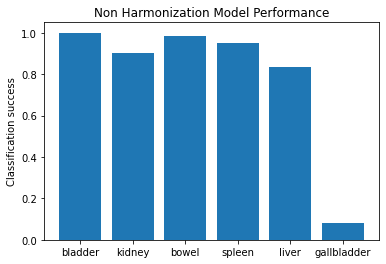

In [8]:
model_name = "us_without_harmonization"
plot_title = "Non Harmonization Model Performance"
get_validation_stats(model_name, plot_title)

### 4.2 With FDA

-----------------------MODEL OPTIONS------------------------
Name                     ---->                   us_fda
Device                   ---->                      cpu
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        6
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->             CrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       20
Image_size               ---->                 (64, 64)
Num_threads              ---->                        4
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                 (0, 255)



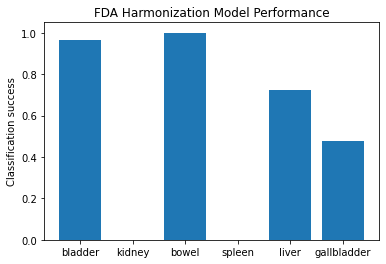

In [9]:
model_name = "us_fda"
plot_title = "FDA Harmonization Model Performance"
get_validation_stats(model_name, plot_title)

### 4.3 With CycleGan

-----------------------MODEL OPTIONS------------------------
Name                     ---->              us_cyclegan
Device                   ---->                      cpu
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        6
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->             CrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       20
Image_size               ---->                 (64, 64)
Num_threads              ---->                        4
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                 (0, 255)



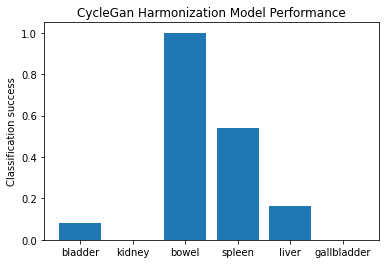

In [10]:
model_name = "us_cyclegan"
plot_title = "CycleGan Harmonization Model Performance"
get_validation_stats(model_name, plot_title)